In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import warnings
from sklearn.metrics import classification_report
from scipy.special import xlogy, xlog1py 
import random
from tqdm.notebook import tqdm
InteractiveShell.ast_node_interactive = "all"
warnings.filterwarnings("ignore")

### Theory

Consider a system where:

\begin{equation}
h^t= f (h^{t-1},\theta)  
\end{equation}
\begin{equation}
\theta \text{: parameters shared across all time steps}
\end{equation}

That is, its state at time step t, is dependent only on a set a parameters and the previous state at t-1
<br>
<br>
Let the state of the system, h, also be depedent on an input at the respective time step, x:

\begin{equation}
h^t= f (h^{t-1},x^{t},\theta)  
\end{equation}

The state h now contains information about the entire past history of inputs, x.

Consider now a system that given the hidden state, h,produces an output o, for each time step. This output is passed to an activation function made to predict the target, y, at the respective time step.

\begin{equation}
o^t= g (h^{t},\theta')  
\end{equation}
\begin{equation}
\theta' \text{: a different set of parameters as $\theta$}
\end{equation}


We define now define $\theta$ and $\theta'$ as the weight matrices describing the relation between the input-to-hidden, hidden-to-hidden and hidden-to-output notes; $U$, $W$ and $V$:

\begin{equation}
z^t=  W^{T}h^{t-1} + U^{T}x^t +b 
\end{equation}

\begin{equation}
h^{t} = \phi(z^t)
\end{equation}

\begin{equation}
o^t = V^Th^{t} + c
\end{equation}

Where $b$ and $c$ are biases, $\phi$ is an activation function. <br><br>
**Note**: matrices $U$, $W$ and $V$ are not indexed by time. 

consider the following schematic to get a better understanding for a reccurent system
<img src="media/RNNFoldedandUnfolded.png" style="height: 300px;"/>
credits: fdeloche 

Then for each time step, we have a sequential total loss up to time step $\tau$, $L^\tau$, defined as the difference between our prediction and the target, at each output, upto the time step $\tau$
<br>
<br>
Consider the task of multi-class classification. 
<br>
<br>
Consequently, the output activation function is the normalized expontential function, a.k.a the _softmax function_

\begin{equation}
L = \sum_{t=1}^{\tau} l\big(o^{t}\big)
\text{: Total loss upto time step $\tau$}  
\end{equation}

\begin{equation}
\hat{y}^t_i = \frac{\exp(o_i^t)}{\sum_{j}\exp(o_j^t)}
\text{: Softmax activation function for multi-class classification}
\end{equation}

**NOTE** the softmax is a vector function, later when taking the derivative, in reality I am finding the Jacobian of it in its vector form, but here I denote one element of it, the $i^{th}$

\begin{equation}
l = - \sum_{m=0}^{M-1}y_{m}^{t} \log\Big(\hat{y}_{m}^{t}\Big)
\text{: M categorical cross entropy for predictions at time step $t$}
\end{equation}


The optimization process differs from standard back-propagation (like descirbed for a vanilla feedforward network). Usng the above assumptions, I will go through the derivation analogous optimization process for recurrent networks;

### Back propagation through time

Per example loss w.r.t to the output element $o_i$ at time $t$; $o_i^{t}$

\begin{equation}
\nabla_{o_{i}^{t}} L = \frac{\partial{L}}{\partial{l(o_i^t)}} \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}}
\end{equation}
Note that:
\begin{equation}
 \frac{\partial{L}}{\partial{l(o_i^t)}} = 1
\end{equation}
and that:
\begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}}
\end{equation}
is the derivative of the categorical cross-entropy
\begin{equation}
\boxed{
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = - \sum_{j} \frac{y_j^{t}}{\hat{y}_j^{t}}\frac{\partial{\hat{y}^{t}_j}}{\partial{o_i^{t}}} } - [1]
\end{equation}
The softmax functions is:
 \begin{equation}
 \hat{y}^t_i = \frac{\exp(o_i^t)}{\sum_{j}\exp(o_j^t)}
\end{equation}
Taking its derivative gives:
\begin{equation}
\boxed{
    \frac{\partial{\hat{y}^{t}_i}}{\partial{o_j^{t}}} = \hat{y}^{t}_{i} \Big( \delta_{ij}  -  \hat{y}^{t}_{j} \Big)
}- [2]
\end{equation}
_look at the different cases to see why this is true_ i.e. $i=j$ and $i \neq j$
<br><br>
Lets sub [2] into [1], and splitting into the cases where $i=j$ and $i \neq j $:

 \begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = - \sum_{j} \frac{y_j^{t}}{\hat{y}_j^{t}} \hat{y}^{t}_{j} \Big(\delta_{ij}  -  \hat{y}^{t}_{i} \Big)
\end{equation}

 \begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = - \sum_{j} y_j^{t} \Big(\delta_{ij}  -  \hat{y}^{t}_{i} \Big)
\end{equation}
 
Lets now split the sum up for the two cases;

\begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} \Bigr|_{j=i} + \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} \Bigr|_{j \neq i}  =  -y^{t}_{i}(\delta_{ii} - \hat{y}_{i})^{t} - \sum_{j \neq i} y_j^{t} \Big(\delta_{ij}  -  \hat{y}^{t}_{i} \Big)
\end{equation} 
Simplfying down: 

\begin{equation}
 
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  -y^{t}_{i}(1 - \hat{y}_{i})^{t} - \sum_{j \neq i} y_j^{t} \Big( 0 -\hat{y}^{t}_{i} \Big)
\end{equation} 

\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j \neq i} y_j^{t} \hat{y}^{t}_{i}  -y^{t}_{i}(1 - \hat{y}_{i})^{t} 
\end{equation} 


\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j \neq i} y_j^{t} \hat{y}^{t}_{i}+y^{t}_{i}\hat{y}_{i}^{t}  -y^{t}_{i}
\end{equation} 
Recall that $\sum_{j} y_j = 1$
\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j \neq i} \Big( y_j^{t} +y^{t}_{i} \Big) \hat{y}^{t}_{i}  -y^{t}_{i}
\end{equation} 


\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j} \Big( y_j^{t} \Big) \hat{y}^{t}_{i}  -y^{t}_{i}
\end{equation} 


\begin{equation}
\boxed{
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  \hat{y}^{t}_{i}  -y^{t}_{i}
}
\end{equation} 

Next, lets calculate the gradient on the internel nodes $h^t$ from the end of the sequence $\tau$.
<br>
I am going to use vector notation here on out. I.e. $h_i^{t}$ becomes $h^t$ 

\begin{equation}
\nabla_{h^\tau} L = \Bigg( \frac{ \partial{o^{\tau}}}
{\partial{h^{\tau}}} \Bigg)^{T} \nabla_{o^\tau} L
\end{equation}

\begin{equation}
\nabla_{h^\tau} L = V \nabla_{o^\tau} L
\end{equation}
we iterate backwards through time. Note the dependency of $h^t$ on both $o^t$ and $h^{t+1}$


\begin{equation}
\nabla_{h^t} L = \Bigg( \frac{ \partial{h^{t+1}}}
{\partial{h^{t}}} \Bigg)^{T} \nabla_{h^{t+1}} L +
\Bigg( \frac{ \partial{o^{t}}}
{\partial{h^{t}}} \Bigg)^{T} \nabla_{o^{t}} L 
\end{equation}




The derivate of the hidden units  w.r.t their previous time step is:

\begin{equation}
 \frac{ \partial{h^{t+1}} }
{\partial{h^{t}} }  =  \frac{ \partial{h^{t+1}} }{ \partial{z^{t+1} } }
\frac{ \partial{z^{t+1} } } { \partial{h^{t}} }
\end{equation}
This leads to:

\begin{equation}
 \frac{ \partial{h^{t+1}} }
{\partial{h^{t}} }  =  diag\Bigg( \phi'\big(z^{t+1}\big) \Bigg) W^T
\end{equation}
**Note** diag: considering only the leading diagonal values and setting all others to 0. 
<br><br>
For RNNs , we want to use a saturating activation to avoid gradient explosions <br><br>
e.g. hyperbolic tagent. 

\begin{equation}
\nabla_{h^t} L = W  diag \Big( \phi'\big(z^{t+1}\big) \Big)   \nabla_{h^{t+1}} L +
V \nabla_{o^{t}} L 
\end{equation}


Lets specify the activation function (using the hyperpolic tagent)

\begin{equation}
\nabla_{h^t} L = W  diag \Big( 
     1 - \big(h^{t+1}\big)^2
    \Big)  \nabla_{h^{t+1}} L +
V \nabla_{o^{t}} L 
\end{equation}

Now for the gradients on the biases $b$ and $c$

\begin{equation}
\nabla_{c} L  = \sum_{t} \Bigg(
     \frac{\partial{o^t}}{\partial{c^t}} 
     \Bigg)^{T} \nabla_{o^t} L
\end{equation}
since $\frac{\partial{o^t}}{\partial{c^t}} = 1$

\begin{equation}
\boxed{\nabla_{c} L  = \sum_{t} \nabla_{o^t} L }
\end{equation}
Next:
\begin{equation}
\nabla_{b} L  = \sum_{t}  \Bigg(
     \frac{\partial{h^t}}{\partial{b^t}} 
     \Bigg)^{T}  \nabla_{h^t} L
\end{equation}
Since $b$ is dependent on h through the activation function $\phi$, we have: 

Next:
\begin{equation}
\boxed{
\nabla_{b} L  = \sum_{t}  diag \Bigg( \phi' \Big( z^t \Big) \Bigg) \nabla_{h^t} L }
\end{equation}

The derivative w.r.t to $V$; the hidden-ouput matrix 

\begin{equation}
\nabla_{V} L  = \sum_{t} \sum_{i}  \Bigg(
    \frac{ \partial L}{ \partial o_{i}^t}
     \Bigg)^T \nabla_{V} O_i^{t}
\end{equation}
Leading to:
\begin{equation}
\boxed{
\nabla_{V} L  = \sum_{t} h^t \Big(\nabla_{o^t} L \Big)^T
}
\end{equation}

For the derivative w.r.t the weight matrices $W$ and $U$, we introduce dummy variables $W^t$ and $U^t$. These are copies of each other at each time step, summing these up will give us the total gradient. 


\begin{equation}
\nabla_{W} L  = \sum_{t} \sum_{i}  \Bigg(
    \frac{ \partial L}{ \partial h_{i}^t}
     \Bigg)^T \nabla_{W^t} h_i^{t}
\end{equation}
giving: 
\begin{equation}
\boxed{
\nabla_{W} L  = \sum_{t} h^{t-1} \Big(\nabla_{h^t} L \Big)^T  diag \Bigg( \phi ' \big(z^t \big) \Bigg)

}
\end{equation}
for the derivative of w.r.t $U$:

\begin{equation}
\nabla_{U} L  = \sum_{t} \sum_{i}  \Bigg(
    \frac{ \partial L}{ \partial h_{i}^t}
     \Bigg)^T \nabla_{U^t} h_i^{t}
\end{equation}
giving: 
\begin{equation}
\boxed{
\nabla_{U} L  = \sum_{t} x^{t} \Big( \nabla_{h^t} L \Big)^T 
     diag \Bigg( \phi ' \big(z^t \big) \Bigg)

}
\end{equation}


Hence the update equations are: 
<br>
<br>
$W \rightarrow W - \alpha \nabla_{W} L$ 
<br>
<br>
$U\rightarrow U - \alpha \nabla_{U} L$
<br>
<br>
$V\rightarrow V - \alpha \nabla_{V} L$ 
<br>
<br>
$b \rightarrow b - \alpha \nabla_{b} L$
<br>
<br>
$c \rightarrow c - \alpha \nabla_{c} L$
<br>
<br>

# Recurrent neural network implementation with backpropagation

In [5]:
class RNN:
    def __init__(self, input_dim, output_dim, hidden_dim, idx2wave):
        # network variables 
        self.idim = input_dim
        self.hdim = hidden_dim
        self.odim = output_dim
        # initialise weights 
        self.U = np.random.uniform(- np.sqrt(1./self.idim),
                                     np.sqrt(1./self.idim),
                                    (self.idim, self.hdim))

        self.V = np.random.uniform( -np.sqrt(1./self.hdim),
                                     np.sqrt(1./self.hdim), 
                                    (self.hdim,self.odim))

        self.W = np.random.uniform( -np.sqrt(1./self.hdim),
                                     np.sqrt(1./self.hdim), 
                                    (self.hdim,self.hdim))
        # bias init 
        self.b = np.zeros(self.hdim)
        self.c = np.zeros(self.odim)

        self.idx2wave = idx2wave 

    def softmax(self,x):
        '''
        Note that this is a numerically stable version of softmax.
        We substract the max value from all elements.
        Overflow of a single element, or underflow of all elements,  will render the output usless.
        subtracting max leaves only non-positive values ---> no overflow 
        at least one element = 0 ---> no vanishing denominator (underflow is some enteries is okay) 
         '''
        xt = np.exp(x-np.max(x))
        return xt / np.sum(xt)


    def forward(self,x):
        # Single example pass forward, all the way through the network
        T = len(x)
        # will stack as rows
        h = np.zeros((T,self.hdim))
        o = np.zeros((T,self.odim))
        for t in range(T):
            h[t] = self.U.T @ x[t] + self.b
            if t > 1:
                h[t] += self.W @ h[t-1] + self.b
            h[t] = np.tanh(h[t])
            o[t] = self.softmax( self.V.T @ h[t] + self.c)
        return (o,h)



    def backward(self, x, y, clip=None):
        T = len(x)
        o,h = self.forward(x)
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        dLdb = np.zeros(self.b.shape)
        dLdc = np.zeros(self.c.shape)
        # dL/do
        delta_o = o
        # Notice, only evaluting at last output of network, yHat - y 
        delta_o[ np.arange(T), y ] -= float(y) 
        # dL/dh
        delta_h = np.zeros((T, self.hdim))

        for t in reversed(range(T)):
            
            # collect errors on hidden states
            delta_h[t] = self.V @ delta_o[T-1,:]

            if t < T-1:
                # collect errors on hidden states due to W
                delta_h[t] = ( self.W @ np.diag(1-h[t+1]**2) ) @ delta_h[t+1]
                
        for t in range(T):
            # error on ouput bias
            dLdc += delta_o[T-1,:]
            # error on hidden bias 
            dLdb += (1-h[t]**2) * delta_h[t,:]
            # error on hidden-output matrix
            ot = delta_o[T-1,:][...,np.newaxis]
            ht = h[t,:][...,np.newaxis]
            dht = delta_h[t,:][...,np.newaxis]

            dLdV += ht @ ot.T 
            # error on hidden-hidden W
            if t > 0 :
                h_t = h[t-1,:][...,np.newaxis]
                dLdW += ( h_t @ dht.T )@np.diag(1-h[t]**2)
            xt = x[t][...,np.newaxis]
            dLdU += xt @ dht.T @ np.diag(1-h[t]**2)

        if clip is not None:
            dLdb = np.clip(dLdb, -clip, clip)
            dLdc = np.clip(dLdc, -clip, clip)
            dLdV = np.clip(dLdV, -clip, clip)
            dLdW = np.clip(dLdW, -clip, clip)
            dLdU = np.clip(dLdU, -clip, clip)
        return (dLdU, dLdV, dLdW, dLdb, dLdc)


    def step(self,x,y,lr=0.0001):
        dLdU, dLdV, dLdW, dLdb, dLdc = self.backward(x,y)
        self.U -= lr * dLdU
        self.V -= lr * dLdV
        self.W -= lr * dLdW 
        self.b -= lr * dLdb 
        self.c -= lr * dLdc 
    

    def Loss(self, x,y):
        o,h = self.forward(x)      
        yHat= o[len(x)-1, :]
        y_1h = [0.0]*len(yHat)
        y_1h[int(y)] = 1.0
        LOSS = self.categorical_cross_entropy_loss(yHat, y_1h)
        return LOSS


    def categorical_cross_entropy_loss(self, yHats, ys):
        loss = 0.0
        e =  1e-15 # adding to pred values for numerical stability
        for pred,true in zip(yHats, ys):
            loss += -1.0*(xlogy(true, pred+e) + xlog1py(1.0-true,-pred+e))
        return loss

    def predict(self,x):
        o,_ = self.forward(x)
        output = list(o[len(x)-1, :]) 
        return output.index(max(output))


# Modelling synthetic time series data

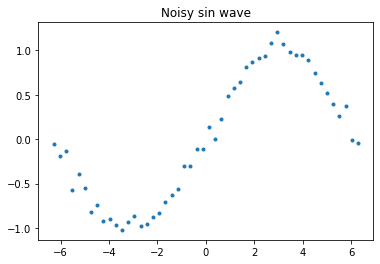

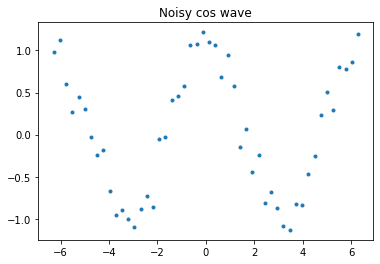

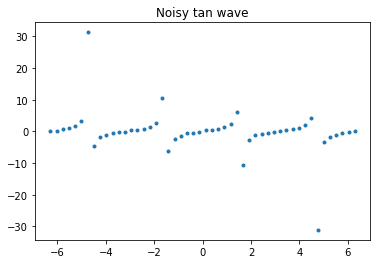

In [7]:
X = np.linspace(-2*np.pi, 2*np.pi, 50)


def noisy_sin_wave(x):
    return np.sin(x*0.5) + np.random.normal(loc=0, scale=0.1)


def noisy_cos_wave(x):
    return np.cos(x) + np.random.normal(loc=0, scale=0.2)


def noisy_tan_wave(x):
    return np.tan(x) + np.random.normal(loc=0, scale=0.1)


def plot_noisy_func(func, domain,title):
    fig, ax = plt.subplots(1,1)
    ax.set_title(title)
    ax.plot(domain,np.vectorize(func)(domain), ".")


def create_sample_seq(func1, domain, label):
    X = np.array([np.vectorize(func1)(domain)])
    Y = np.array([label]*X.shape[0])
    X = X.T
    return X,Y

plot_noisy_func(noisy_sin_wave, X, "Noisy sin wave")
plot_noisy_func(noisy_cos_wave, X, "Noisy cos wave")
plot_noisy_func(noisy_tan_wave, X, "Noisy tan wave")

## synthetic data generation 

In [10]:
def data_loader(domain, sample_size=50):
    X0 = [ create_sample_seq(noisy_sin_wave, domain, 0) for _ in range(sample_size)]
    X1 = [ create_sample_seq(noisy_cos_wave, domain, 1) for _ in range(sample_size)]
    X2 = [ create_sample_seq(noisy_tan_wave, domain, 2) for _ in range(sample_size)]
    X = [*X0, *X1 , *X2]
    random.shuffle(X)
    idx2wave = {0:"sin", 1:"cos", 2:"tan"}
    return X, idx2wave

# Training the model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Loss 0.004082467912173554
Epoch 1 Loss 0.0005056370758446926
Epoch 2 Loss 0.0005636497992824555
Epoch 3 Loss 0.00047894372122469326
Epoch 4 Loss 1.1615791984162178e-05
Epoch 5 Loss 2.2236428731659063e-07
****************************************
Termination condition met at epoch: 5.
****************************************
              precision    recall  f1-score   support

         sin       1.00      0.70      0.82        20
         cos       1.00      1.00      1.00        20
         tan       0.77      1.00      0.87        20

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



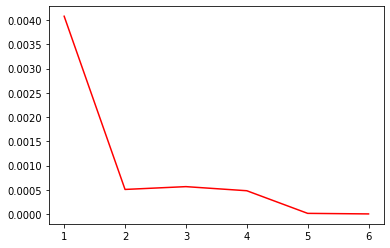

In [9]:
loss_history = []
MAX_EPOCHS = 50
LR=0.001


domain = np.linspace(-2*np.pi, 2*np.pi, 50)
X, idx2wave = data_loader(domain,sample_size=100)
model = RNN(input_dim=1, output_dim=3, hidden_dim=128, idx2wave=idx2wave)


for epoch in tqdm(range(MAX_EPOCHS)):
    loss = 0
    for pair in X:
        x,y  = pair        
        loss += model.Loss(x, y)
        model.step(x, y, lr=LR)
        loss = loss / len(x)
    print(f"Epoch {epoch} Loss {loss}")
    loss_history.append(loss)
    if loss < 1e-5:
        print("*"*40)
        print(f"Termination condition met at epoch: {epoch}.")
        print("*"*40)
        break 



X, idx2wave = data_loader(domain, sample_size=20)
true, pred = [], []
for idx in range(len(X)):
    x, y = X[idx][0],X[idx][1]
    out = model.predict(x)
    true.append(list(y)[0])
    pred.append(out)




              precision    recall  f1-score   support

         sin       1.00      0.70      0.82        20
         cos       1.00      1.00      1.00        20
         tan       0.77      1.00      0.87        20

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



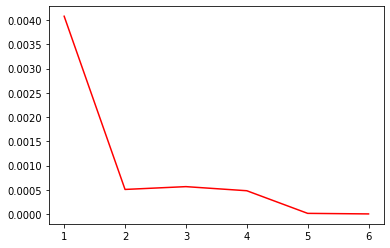

In [11]:
target_names = list(idx2wave.values())
plt.plot(np.arange(1, len(loss_history)+1, 1), loss_history, c="r")
print(classification_report(true,pred, target_names=target_names))